필요한 모듈 다운로드

In [97]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")

# 기본
import string
import pandas as pd
import numpy as np
import contractions
import re

# 데이터 전처리
import nltk
from nltk.tag import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
import gensim
import heapq
from operator import itemgetter
from multiprocessing import Pool

# 감성 분석
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

# 데이터 시각화
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from PIL import Image

데이터 불러오기

In [121]:
df = pd.read_csv("Bukchon Hanok Village.csv")

In [122]:
#열 삭제 
df = df.loc[:,['STAR','CONTENT']]

토큰화 & 불용어 제거

In [123]:
def text_clearing(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9]+',' ',str(text))
    text = [word.strip(string.punctuation) for word in text.split()]
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    text = [t for t in text if len(t)>0]
    pos_tags = pos_tag(text)
    text = [t for t in text if len(t)>1]
    text = " ".join(text)
    return(text)

In [124]:
df["CONTENT"]= df["CONTENT"].apply(lambda x:text_clearing(x))
df

,STAR,CONTENT
0,5.0,beautiful old village definitely try wear hanb...
1,5.0,amazing place house designs attractive best we...
2,5.0,nice clean peaceful place live lots generous p...
3,5.0,walk around culture seoul
4,5.0,village old houses visited architecture remark...
...,...,...
2837,5.0,going place really cultural walk houses hanok ...
2838,5.0,peaceful quiet place afternoon tea numerous ca...
2839,4.0,saw korean traditional house small back street...
2840,4.0,spent sunday afternoon lots nice cafe gallery ...


Lemmatization

In [125]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J':wordnet.ADJ, 'N':wordnet.NOUN, 'V':wordnet.VERB, 'R':wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Lemmatization
lemma = WordNetLemmatizer()
def text_lemmatizer(text):
    lemmatizer_words = " ".join([lemma.lemmatize(word, get_wordnet_pos(word)) for word in word_tokenize(text)])
    return lemmatizer_words

In [126]:
df["CONTENT"]=df["CONTENT"].apply(lambda x:text_lemmatizer(x))
df

,STAR,CONTENT
0,5.0,beautiful old village definitely try wear hanb...
1,5.0,amaze place house design attractive best wear ...
2,5.0,nice clean peaceful place live lot generous pe...
3,5.0,walk around culture seoul
4,5.0,village old house visit architecture remarkable
...,...,...
2837,5.0,go place really cultural walk house hanok styl...
2838,5.0,peaceful quiet place afternoon tea numerous ca...
2839,4.0,saw korean traditional house small back street...
2840,4.0,spent sunday afternoon lot nice cafe gallery c...


VADER (Sentiment Analysis)

In [127]:
# Compound score 측정
vd=[]
sia = SentimentIntensityAnalyzer()
for a in df['CONTENT']:
    vd.append(sia.polarity_scores(a)['compound'])
df['COMPOUND']=vd

In [128]:
# 긍부정 분석
senti = []
for a in df.COMPOUND.astype(float):
    if a >= 0.05:
        senti.append("Positive")
    elif a<= -0.01:
        senti.append("Negative")
    else: 
        senti.append("Neutral")

df["VADER"] = senti
df = df.loc[:,['CONTENT','VADER']]
df

,CONTENT,VADER
0,beautiful old village definitely try wear hanb...,Positive
1,amaze place house design attractive best wear ...,Positive
2,nice clean peaceful place live lot generous pe...,Positive
3,walk around culture seoul,Neutral
4,village old house visit architecture remarkable,Positive
...,...,...
2837,go place really cultural walk house hanok styl...,Positive
2838,peaceful quiet place afternoon tea numerous ca...,Positive
2839,saw korean traditional house small back street...,Positive
2840,spent sunday afternoon lot nice cafe gallery c...,Positive


In [129]:
# 중복 데이터 제거
df['CONTENT'].nunique(), df['VADER'].nunique()

# Null 값 존재 여부 확인
print(df.isnull().values.any())

# NULL 값이 존재한다면, 
# vd.data.loc[vd.CONTENT.isnull()]

False


<AxesSubplot:>

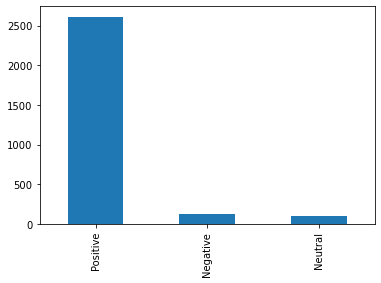

In [130]:
# 긍부정 분포 
df['VADER'].value_counts().plot(kind='bar')

긍부정 나누기

In [131]:
# Positive Only
df_p = df[df['VADER'].str.contains('Positive')]

# Negative Only
df_n = df[df['VADER'].str.contains('Negative')]

Positive Content 처리

In [132]:
all_p =''
for i in range(len(df_p['CONTENT'])):
    all_p= all_p+''+df_p['CONTENT'].iloc[i]    
str(all_p)

# 토큰화
tokenized_p = word_tokenize(all_p)

# 품사 태깅
line_p = nltk.pos_tag(tokenized_p)

# 단어 중 명사만 추출
noun_p = []
for word, pos in line_p:
    if 'NN' in pos:
        noun_p.append(word)

In [133]:
pos_tag(noun_p)

[('village', 'NN'),
 ('visit', 'NN'),
 ('area', 'NN'),
 ('place', 'NN'),
 ('house', 'NN'),
 ('design', 'NN'),
 ('hanbok', 'JJ'),
 ('picture', 'NN'),
 ('speak', 'JJ'),
 ('cant', 'JJ'),
 ('people', 'NNS'),
 ('place', 'VBP'),
 ('lot', 'JJ'),
 ('people', 'NNS'),
 ('love', 'VBP'),
 ('livingvillage', 'NN'),
 ('house', 'NN'),
 ('visit', 'NN'),
 ('architecture', 'NN'),
 ('remarkablegood', 'NN'),
 ('kotagede', 'VB'),
 ('yogyakarta', 'JJ'),
 ('town', 'NN'),
 ('charge', 'NN'),
 ('entry', 'NN'),
 ('houseplace', 'VBP'),
 ('detour', 'JJ'),
 ('opinion', 'NN'),
 ('architecture', 'NN'),
 ('place', 'NN'),
 ('mustsee', 'VBP'),
 ('seoulhard', 'RB'),
 ('climb', 'JJ'),
 ('worthbeautiful', 'JJ'),
 ('house', 'NN'),
 ('sky', 'NN'),
 ('reminder', 'NN'),
 ('use', 'NN'),
 ('voice', 'NN'),
 ('resident', 'JJ'),
 ('housetry', 'NN'),
 ('trail', 'NN'),
 ('village', 'NN'),
 ('hanok', 'NN'),
 ('style', 'NN'),
 ('housenice', 'NN'),
 ('place', 'NN'),
 ('visit', 'NN'),
 ('walk', 'VBP'),
 ('seoul', 'NN'),
 ('royal', 'NN'),


Negative Content 처리

In [135]:
all_n =''
for i in range(len(df_n['CONTENT'])):
    all_n= all_n+''+df_n['CONTENT'].iloc[i]    
str(all_n)

# 토큰화
tokenized_n = word_tokenize(all_n)

# 품사 태깅
line_n = nltk.pos_tag(tokenized_n)

# 단어 중 명사만 추출
noun_n = []
for word,pos in line_n:
    if 'NN' in pos:
        if len(word)>1:
            noun_n.append(word)

오타, 띄어쓰기 처리

긍부정 공통 단어 처리

긍정 단어 Wordcloud

In [141]:
# 언급횟수 측정
counts = Counter(noun_p)
rank_p = counts.most_common(100)

# 단어 처리
rank = dict(rank_p)
stopword = stopwords.words('english')
max_len = 100
min_len = 10
temp_dic_p = {}

for key, value in rank.items():
    if value < max_len and value > min_len:
        temp_dic_p[key] = value
rank_p = temp_dic_p

for key, value in rank.items():
    if key not in stopword:
        temp_dic_p[key]=value

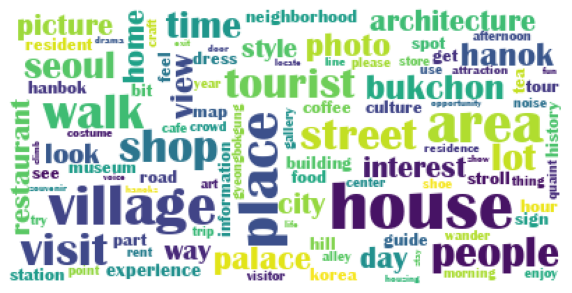

In [142]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/BRITANIC.ttf',background_color='white',max_font_size = 50)
wc = wordcloud.generate_from_frequencies(temp_dic_p)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

부정 단어 Wordcloud

In [143]:
# 공통
common = list(set(noun_p)&set(noun_n))

# 정제된 Positive Content
noun_p = list(set(noun_p)-set(common))

# 정제된 Negative Content
noun_n = list(set(noun_n)-set(common))

In [144]:
# 언급횟수 측정
counts = Counter(noun_n)
rank_n = counts.most_common(100)

# 단어 처리
rank = dict(rank_n)
stopword = stopwords.words('english')
max_len = 1000
min_len = 0
temp_dic_n = {}
for key, value in rank.items():
    if value< max_len and value > min_len:
        temp_dic_n[key] = value
rank = temp_dic_n

for key, value in rank.items():
    if key not in stopword:
        temp_dic_n[key]=value

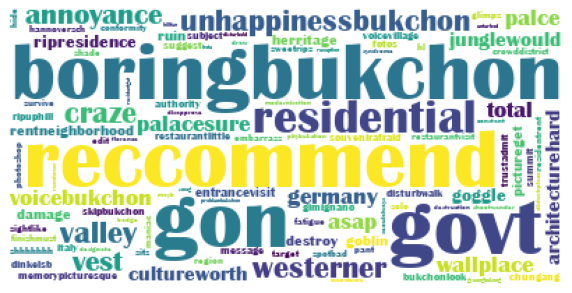

In [145]:
wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/BRITANIC.ttf',background_color='white',max_font_size = 60)
wc = wordcloud.generate_from_frequencies(temp_dic_n)

plt.figure(figsize=(10,8))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [39]:
# 공통
common = list(set(noun_p)&set(noun_n))

# 정제된 Positive Content
noun_p = list(set(noun_p)-set(common))

# 정제된 Negative Content
noun_n = list(set(noun_n)-set(common))

In [ ]:
def listToString(str_list):
    result = ""
    for s in str_list:
        result += s+ " "
    return result.strip()

noun_n = pd.DataFrame(noun_n)